In [2]:
import numpy as np
import random as rnd
import time as tm
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
Z = np.loadtxt( "data" )
#np.random.shuffle(Z)
d = Z.shape[1]-1
n = Z.shape[0]
y = Z[:,0]
X = Z[:,1:]
lim = int(0.8*n)
train_x = Z[:lim,1:]
train_y = Z[:lim,0]
test_x = Z[lim:,1:]
test_y = Z[lim:,0]

In [4]:
# Get a mini-batch stochastic gradient for CSVM
# Choose a random set of B samples per iteration
def getCSVMMBGrad( theta ):
    w = theta[0:-1]
    b = theta[-1]
    n = y.size
    if B <= lim:
        samples = rnd.sample( range(0, lim), B )
        X_ = X[samples,:]
        y_ = y[samples]
    else:
        X_ = X
        y_ = y
    discriminant = np.multiply( (X_.dot( w ) + b), y_ )
    g = np.zeros( (B,) )
    g[discriminant < 1] = -1
    delb =   C * n/B * g.dot( y_ * np.maximum( 1 - np.multiply( (X_.dot( w ) + b), y_ ), 0 ))
    
    #print(np.maximum( 1 - np.multiply( (X_.dot( w ) + b), y_ ), 0 ).shape,w.shape,(X_.T * g).dot( y_ ).shape)
    delw = w + 2.0* C * n/B * (X_.T * g).dot( y_ * np.maximum( 1 - np.multiply( (X_.dot( w ) + b), y_ ), 0 ))  
    #print("Delb = "+str(delb)+" delw = "+str(delw))
    return np.append( delw, delb )

In [5]:
# Quite standard for strongly convex but non-smooth objectives like CSVM
def getStepLength( grad, t ):
    return eta/(t+1)

In [6]:
# Get the CSVM objective value in order to plot convergence curves
def getCSVMObjVal( theta ):
    w = theta[0:-1]
    b = theta[-1]
    hingeLoss = np.maximum( 1 - np.multiply( (X.dot( w ) + b), y ), 0 )
    #print("Hinge loss = "+str(hingeLoss))
    return 0.5 * w.dot( w ) + C * np.dot(hingeLoss,hingeLoss.T)

In [7]:
# Given a gradient oracle, a step length oracle, an initialization,
# perform GD for a specified number of steps (horizon)
# An "oracle" is a fancy name for a function that does a certain job perfectly
def doGD( gradFunc, stepFunc, init, horizon = 10 ):
    objValSeries = np.zeros( (horizon,) )
    timeSeries = np.zeros( (horizon,) )
    totTime = 0
    theta = init
    cumulative = init
    for t in range( horizon ):
        tic = tm.perf_counter()
        delta = gradFunc( theta )
        theta = theta - stepFunc( delta, t+1 ) * delta
        cumulative = cumulative + theta
        toc = tm.perf_counter()
        totTime = totTime + (toc - tic)
        objValSeries[t] = getCSVMObjVal( cumulative/(t+2) )
        timeSeries[t] = totTime
        #print(t)
    return (cumulative/(horizon+1), objValSeries, timeSeries)

In [8]:
#Validation Run
C = 1
eta = 0.001
B = 600
X = train_x
y = train_y
(theta_MB, obj_MB, time_MB) = doGD( getCSVMMBGrad, getStepLength, np.zeros( (d+1,) ), horizon = 10000 )

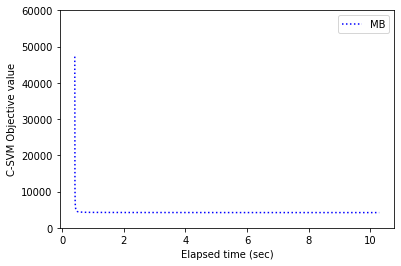

In [10]:
#plt.figure( (7,7) )
#plt.plot( time, obj, color = 'k', linestyle = '--', label = "GD" )
#plt.plot( time_SGD, obj_SGD, color = 'r', linestyle = '-', label = "SGD" )
plt.plot( time_MB, obj_MB, color = 'b', linestyle = ':', label = "MB" )
plt.xlabel( "Elapsed time (sec)" )
plt.ylabel( "C-SVM Objective value" )
plt.legend()
plt.ylim( 0,60000 )
plt.show()

In [11]:
# Validation Error
y = test_y
X = test_x
getCSVMObjVal(theta_MB)
print(obj_MB[-1])

4195.356033463064


In [12]:
# Final Training
C = 1
eta = 0.001
B = 600
y = Z[:,0]
X = Z[:,1:]
(theta_MB, obj_MB, time_MB) = doGD( getCSVMMBGrad, getStepLength, np.zeros( (d+1,) ), horizon = 5000 )

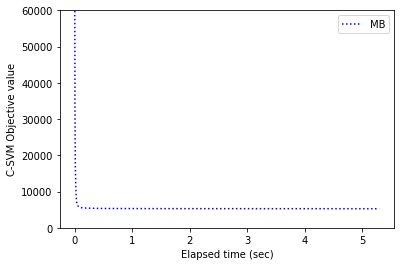

In [13]:
plt.plot( time_MB, obj_MB, color = 'b', linestyle = ':', label = "MB" )
plt.xlabel( "Elapsed time (sec)" )
plt.ylabel( "C-SVM Objective value" )
plt.legend()
plt.ylim( 0,60000 )
plt.show()

In [14]:
theta_MB[:-1]

array([-0.7971163 ,  0.04951356, -0.13769291,  0.36743524,  0.47448311,
        0.09782217, -3.4636221 ,  0.3196247 ,  0.05837583,  0.9806736 ,
       -1.24863046, -0.30689449,  0.34884538,  0.31235398, -0.14092719,
        0.8742932 ,  0.26505327,  0.27104115,  0.10355303, -0.37055113])

In [15]:
theta_MB[-1]

-0.8724698883551504

In [16]:
import pickle

In [17]:
file = open("data.dat","rb")

In [18]:
b = pickle.load(file,encoding='bytes')

In [19]:
time_ac = b[0]

In [20]:
obj_ac = b[1]
obj_ac[-1]

5837.565624957553

In [21]:
time_sdcm = np.load("sdcm_time") 

In [22]:
time_sdcm

array([ 0.06565339,  0.06568926,  0.06572551, ..., 18.64310674,
       18.6431883 , 18.64324871])

In [23]:
obj_sdcm = np.load("obj_sdcm")

In [24]:
obj_sdcm

array([10632.29715298,  8389.75884964,  7743.20469779, ...,
        5427.95047554,  5315.63113218,  5296.81541519])

In [26]:
# Comparing Minibatch Gradient descent, Coordinate Maximization on dual and Coordinate ascent
plt.figure(figsize = (14,10),dpi =1000)
plt.plot( time_MB, obj_MB, color = 'r', linestyle = '-', label = "MBGD")
plt.plot( time_sdcm, obj_sdcm, color = 'b', linestyle = '-', label = "SDCM")
plt.plot( time_ac, obj_ac, color = 'g', linestyle = '-', label = "SDCA" )
plt.xlabel( "Elapsed time (sec)" )
plt.ylabel( "Primal Objective (P1) value" )
plt.legend()
plt.ylim( 0,60000 )
plt.show()